### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [22]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [3]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [250]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(79162, 41)

(6405, 41)

(6311, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    6405.000000
mean      285.996565
std         0.816362
min       285.000000
25%       285.000000
50%       286.000000
75%       287.000000
max       287.000000
Name: prd, dtype: float64

count    6311.000000
mean      288.997782
std         0.816235
min       288.000000
25%       288.000000
50%       289.000000
75%       290.000000
max       290.000000
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 59.5159478187561
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997


[I 2022-09-07 17:18:26,467] A new study created in memory with name: no-name-44bb9e93-7dfe-4604-8850-65bd640ff05c
[I 2022-09-07 17:18:27,112] Trial 0 finished with value: -0.001414592072799703 and parameters: {'n_estimators': 826, 'max_depth': 4, 'learning_rate': 0.003498941104432466, 'colsample_bytree': 0.5694761739947628, 'subsample': 0.5211493511587894, 'alpha': 0.5193423646858891, 'lambda': 1.0205932866775518, 'gamma': 0.0005441097389351968, 'min_child_weight': 0.10329063537082224}. Best is trial 0 with value: -0.001414592072799703.
[I 2022-09-07 17:18:27,772] Trial 1 finished with value: -0.0011726995494291792 and parameters: {'n_estimators': 865, 'max_depth': 5, 'learning_rate': 0.0039029533369027212, 'colsample_bytree': 0.8986659241488575, 'subsample': 0.10104743664147949, 'alpha': 44.91694825435624, 'lambda': 3.605442214753097, 'gamma': 6.865311436273415, 'min_child_weight': 0.24092611428586455}. Best is trial 1 with value: -0.0011726995494291792.
[I 2022-09-07 17:18:28,500] Tr

Total time for hypermarameter optimization  11.910188913345337
        n_estimators : 1301
           max_depth : 2
       learning_rate : 0.009268982312079108
    colsample_bytree : 0.05600275199565251
           subsample : 0.6665298413314573
               alpha : 1.9761827571723936
              lambda : 5.585601159175016
               gamma : 1.1082169038411447e-10
    min_child_weight : 0.8865122522418047
best objective value : 6.681216376118736e-05
Optuna XGB train: 
 8.262250805377878 0.04952252330599172 
validation 
 7.745393860745202 0.0032156773826091944 9.15082533948575 0.011952688587360427 
test 
 7.8266252847156865 0.019140564759762557


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.049523,0.003216,0.019141


In [6]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train     0.088074
xgbf_val      -0.012211
xgbf_test      0.015254
xgbgs_train    0.060695
xgbgs_val      0.032498
xgbgs_test     0.025239
xgbo_train     0.049523
xgbo_val       0.003216
xgbo_test      0.019141
dtype: float64

87.09774470329285


In [7]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [8]:
optuna_xgb

XGBRegressor(alpha=1.9761827571723936, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.05600275199565251, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=1.1082169038411447e-10, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=5.585601159175016, learning_rate=0.009268982312079108,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
             max_leaves=0, min_child_weight=0.8865122522418047, missing=nan,
             monotone_constraints='()', n_estimators=1301, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

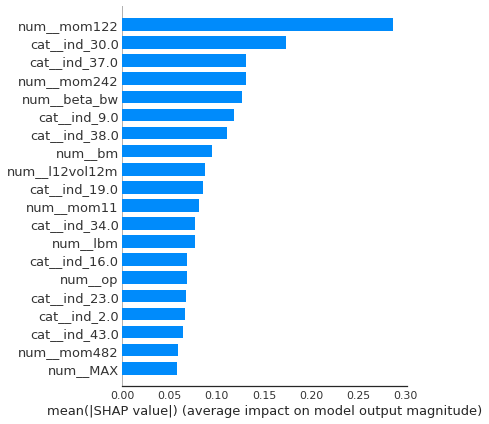

In [9]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [10]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


Min_prd:  250
Constant guess:  7.924561381034317 0.0
XGB test: 7.84572645024662 0.015254350212336232
XGB GS test: 7.787969462570123 0.02523901836111997
Optuna XGB test: 7.8266252847156865 0.019140564759762557


In [11]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  88.09067153930664


In [12]:
results.iloc[:,1:].mean()

xgbf_train     0.088074
xgbf_val      -0.012211
xgbf_test      0.015254
xgbgs_train    0.060695
xgbgs_val      0.032498
xgbgs_test     0.025239
xgbo_train     0.049523
xgbo_val       0.003216
xgbo_test      0.019141
dtype: float64

In [13]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [14]:
display(X_train, X_val, X_test)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
0,-0.574564,-0.711081,0.472308,-0.134353,-1.129718,-0.392313,-0.291318,-0.566625,-0.711182,-0.877729,-0.777803,-0.290435,-0.729070,-0.931525,-1.013542,-1.142541,0.884642,0.282772,-0.127991,-1.106961,-0.536405,1.046549,-0.767426,-0.752765,-0.691502,-1.055559,-0.712044,-0.801846,-0.793977,-0.752765,-0.449638,-0.884437,-0.928455,-0.039010,-1.128689,-1.198377,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.653236,-0.688240,0.472308,-0.134353,-1.129718,-0.392313,-0.256761,-0.281055,-0.725324,-0.863874,-0.841188,-0.390012,-0.914071,-0.929305,-1.037940,-1.204140,0.878183,0.282772,-0.127991,-1.106961,-0.536405,0.976333,-0.720364,-0.738622,-0.729562,-0.627579,-0.666427,-0.880118,-0.766839,-0.738622,-0.432148,-0.441625,-0.316339,0.071654,-1.100925,-1.122707,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.590031,-0.689546,0.472308,-0.134353,-1.129718,-0.392313,-0.247274,-0.277685,-0.762064,-1.125174,-1.126674,-0.400091,-0.890002,-1.089513,-1.077085,-1.203867,0.862794,0.282772,-0.127991,-1.106961,-0.536405,0.958378,-0.734527,-0.921749,-0.788583,-0.745667,-0.697685,-0.599916,-0.750813,-0.921749,-0.711138,-1.087944,-1.068946,0.105760,-1.085436,-1.158464,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.457370,-0.638779,0.472308,-0.134353,-1.129718,-0.392313,0.597571,-0.412356,-0.772104,-0.658278,-0.636945,-0.308280,-0.563560,-0.640612,-1.025729,-1.160449,0.905620,0.282772,-0.127991,-1.106961,-0.536405,0.978536,-0.771321,-0.897924,-0.741403,-0.731403,-0.730937,-1.069933,-0.744892,-0.897924,-0.761080,-0.969431,-0.923707,0.116068,-1.079960,-1.170898,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.604114,-0.623601,0.472308,-0.134353,-1.129718,-0.392313,0.539864,-0.469925,-0.767163,-0.716880,-0.679172,-0.284042,-0.580173,-0.749459,-1.060253,-1.159392,0.945342,0.282772,-0.127991,-1.106961,-0.536405,1.032828,-0.781376,-0.574787,-0.755602,-0.916098,-0.769223,-0.643464,-0.751251,-0.574787,-0.791735,-0.734650,-0.897763,-0.004421,-1.041669,-1.155515,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
36,-0.585324,-0.644216,0.379757,-0.197630,-1.066823,-0.365342,0.388211,-0.899505,-1.038144,-0.560815,-0.445949,-0.416552,-0.303738,-0.659472,-0.982810,-1.166545,1.057885,0.654601,-0.320691,-1.112279,-0.276956,1.216944,-1.089773,-0.902409,-1.187112,-0.977416,-1.333498,-0.924382,-1.189411,-0.902409,0.539004,-0.589160,-0.613450,0.138360,-0.773293,-0.616222,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,-0.726781,-0.772511,0.379757,-0.197630,-1.066823,-0.365342,-0.990431,-0.984266,-0.984656,-0.393243,-0.315458,-0.244301,-0.295420,-0.124462,-0.839646,-1.104340,1.005449,0.654601,-0.320691,-1.112279,-0.276956,1.272056,-1.047810,-0.317597,-1.150335,-0.484600,-1.303997,-0.450954,-1.195741,-0.317597,-0.186181,-0.615879,-0.481990,0.060410,-0.744144,-0.643334,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,-0.719618,-0.431708,0.379757,-0.197630,-1.066823,-0.365342,-0.162117,-1.126915,-0.964176,-0.979260,-0.866734,-0.289412,-0.906472,-0.742458,-0.828203,-1.116244,1.005449,0.654601,-0.320691,-1.112279,-0.276956,1.260143,-0.994242,-0.309362,-1.111737,-0.896592,-1.309644,-1.069933,-1.210686,-0.309362,0.331343,-0.885376,-1.056955,0.024423,-0.842861,-0.659589,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,-0.303435,-1.207074,0.139332,-0.120186,-0.301792,0.217784,0.398875,-1.046352,0.301660,0.074126,0.016825,-0.417008,0.411358,-0.015756,-0.663543,-0.590345,0.318093,-0.045407,0.416153,-0.030640,0.230781,0.503442,0.282370,-0.546595,0.196414,-0.252899,-0.010498,-0.775373,0.086514,-0.546595,-0.519835,0.360269,0.421111,-0.446306,0.136028,-0.091275,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,-0.380104,-1.020176,0.139332,-0.120186,-0.301792,0.217784,0.633951,-0.901490,0.324640,0.380243,0.591793,-0.650563,0.690118,0.252041,-0.472592,-0.656507,0.362862,-0.045407,0.416153,-0.030640,0.230781,0.498180,0.293974,0.390257,0.240561,-0.466554,0.052464,-0.501467,0.075144,0.390257,-1.119754,0.484527,0.439798,-0.325219,0.270547,0.027074,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
39,-0.867368,-0.499066,0.379757,-0.197630,-1.066823,-0.365342,-0.719913,-1.112204,-0.951812,-0.823485,-0.823200,-0.263365,-0.847810,-0.759358,-0.939433,-1.113617,0.960933,0.654601,-0.320691,-1.112279,-0.276956,1.250689,-0.973732,-0.914227,-1.069669,-0.306774,-1.229480,-0.992066,-1.251140,-0.914227,0.966894,-0.782169,-0.887040,-0.205925,-0.916214,-0.819440,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,-0.813073,-0.496274,0.379757,-0.197630,-1.066823,-0.365342,0.469989,-1.102434,-0.895303,-0.483593,-0.413036,-0.226876,-0.565454,-0.561918,-0.899538,-1.067529,0.998287,0.654601,-0.320691,-1.112279,-0.276956,1.214034,-0.961350,-0.856158,-1.015967,-0.298469,-1.192486,-0.500990,-1.317560,-0.856158,1.063903,-0.936993,-0.912128,-0.326780,-0.911090,-0.921379,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,-0.929999,-0.655791,0.379757,-0.197630,-1.066823,-0.365342,-0.795177,-1.090620,-0.873778,-0.981461,-0.907385,-0.229098,-0.911075,-1.073475,-0.913637,-1.073300,0.949190,0.654601,-0.320691,-1.112279,-0.276956,1.241065,-0.904757,-0.576662,-0.995405,-0.908511,-1.153659,-0.911528,-1.374790,-0.576662,0.470431,-1.003227,-1.016788,-0.395446,-1.059311,-0.963268,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,-0.653287,-0.592435,0.139332,-0.120186,-0.301792,0.217784,-0.368547,-0.800143,0.278860,-0.656207,-0.539955,-0.640559,-0.583769,-0.865856,-0.558238,-0.730289,0.327357,-0.045407,0.416153,-0.030640,0.230781,0.499802,0.281703,-0.862803,0.275475,0.407140,0.162234,-0.270107,0.109854,-0.862803,-0.407803,-0.389782,-0.263555,-0.248717,0.162718,0.044085,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,-0.774069,-0.803011,0.139332,-0.120186,-0.301792,0.217784,0.220612,-1.037389,0.297423,-0.625074,-0.481491,-0.609086,-0.852556,-0.668448,-0.591883,-0.773978,0.342443,-0.045407,0.416153,-0.030640,0.230781,0.542960,0.271140,-0.594792,0.298546,0.685439,0.206642,-0.483007,0.032981,-0.594792,0.107700,-0.168599,-0.665567,-0.120194,0.042497,-0.044168,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [15]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

2022-09-07 17:18:43.812428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


219137


2022-09-07 17:18:43.813723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 17:18:43.814580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 17:18:43.815528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 17:18:43.815878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [16]:
neurons_base = 16
l2_reg_rate = 0.4

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal", 
                          input_shape=X_train.shape[1:],
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

26049


In [17]:
neurons_base = 8
l2_reg_rate = 0.3

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn.count_params())

# snn: 32-16-8-4 with 30%l2 reg seems to converge to 5.1% test r2.

3457


2022-09-07 17:18:50.626814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
39/39 - 2s - loss: 150.1036 - mean_squared_error: 134.9699 - val_loss: 134.3322 - val_mean_squared_error: 121.3434
Epoch 2/1000
39/39 - 0s - loss: 144.5756 - mean_squared_error: 133.1774 - val_loss: 131.2944 - val_mean_squared_error: 121.3750
Epoch 3/1000
39/39 - 0s - loss: 141.0446 - mean_squared_error: 132.1308 - val_loss: 128.3966 - val_mean_squared_error: 120.3830
Epoch 4/1000
39/39 - 0s - loss: 138.1486 - mean_squared_error: 130.6927 - val_loss: 126.3911 - val_mean_squared_error: 119.4095
Epoch 5/1000
39/39 - 0s - loss: 135.9481 - mean_squared_error: 129.2906 - val_loss: 125.4822 - val_mean_squared_error: 119.1435
Epoch 6/1000
39/39 - 0s - loss: 134.4322 - mean_squared_error: 128.3903 - val_loss: 124.9000 - val_mean_squared_error: 119.1915
Epoch 7/1000
39/39 - 0s - loss: 133.3543 - mean_squared_error: 127.8983 - val_loss: 125.1949 - val_mean_squared_error: 119.9692
Epoch 8/1000
39/39 - 0s - loss: 132.7072 - mean_squared_error: 127.6958 - val_loss: 124.0461 - val_mean_

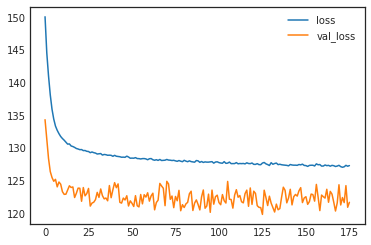

In [18]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [27]:
# try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

def create_snnn_model(trial):

    neurons_base = trial.suggest_int("neurons", 4, 16, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.5)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

    
EPOCHS = 5 # number of epocs per trial

def objective(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn_model(trial)
        
        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=30),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

    
        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model_snn.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        score = model.evaluate(X_val, y_val, verbose=0)
        return score[1]
    
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=10)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    

    

[I 2022-09-07 18:06:56,473] A new study created in memory with name: no-name-99acfebe-bc6d-41c8-926f-2e2c3d995714


Epoch 1/500
39/39 [==============================] - 0s 5ms/step - loss: 125.6054 - mean_squared_error: 124.0280 - val_loss: 123.3122 - val_mean_squared_error: 121.7350
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.5234 - mean_squared_error: 123.9476 - val_loss: 118.3451 - val_mean_squared_error: 116.7806
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 125.4503 - mean_squared_error: 123.8801 - val_loss: 122.5039 - val_mean_squared_error: 120.9308
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 125.4550 - mean_squared_error: 123.8795 - val_loss: 123.4243 - val_mean_squared_error: 121.8470
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 125.2653 - mean_squared_error: 123.6875 - val_loss: 124.5891 - val_mean_squared_error: 123.0060
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 125.5795 - mean_squared_error: 124.0039 - val_loss: 122.3020 - val_mean_squared_er

[I 2022-09-07 18:07:07,561] Trial 0 finished with value: 118.44977569580078 and parameters: {'neurons': 4, 'l2_regularizer': 0.20271051439998727}. Best is trial 0 with value: 118.44977569580078.


Epoch 1/500
39/39 [==============================] - 0s 6ms/step - loss: 125.5492 - mean_squared_error: 123.9750 - val_loss: 122.6149 - val_mean_squared_error: 121.0402
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.4825 - mean_squared_error: 123.8994 - val_loss: 121.4142 - val_mean_squared_error: 119.8399
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 125.7383 - mean_squared_error: 124.1588 - val_loss: 122.7195 - val_mean_squared_error: 121.1424
Epoch 4/500
39/39 [==============================] - 0s 3ms/step - loss: 125.4926 - mean_squared_error: 123.9142 - val_loss: 121.9770 - val_mean_squared_error: 120.4073
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 125.3709 - mean_squared_error: 123.7895 - val_loss: 120.5168 - val_mean_squared_error: 118.9386
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 125.3633 - mean_squared_error: 123.7877 - val_loss: 127.2702 - val_mean_squared_er

[I 2022-09-07 18:07:28,918] Trial 1 finished with value: 119.5679931640625 and parameters: {'neurons': 10, 'l2_regularizer': 0.36294872349247087}. Best is trial 0 with value: 118.44977569580078.


Epoch 1/500
39/39 [==============================] - 0s 6ms/step - loss: 125.4902 - mean_squared_error: 123.9087 - val_loss: 119.9050 - val_mean_squared_error: 118.3328
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.3421 - mean_squared_error: 123.7600 - val_loss: 122.4661 - val_mean_squared_error: 120.8813


[I 2022-09-07 18:07:29,659] Trial 2 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 0s 5ms/step - loss: 125.4849 - mean_squared_error: 123.9016 - val_loss: 122.4004 - val_mean_squared_error: 120.8251
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.6070 - mean_squared_error: 124.0337 - val_loss: 123.5386 - val_mean_squared_error: 121.9734


[I 2022-09-07 18:07:30,301] Trial 3 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 0s 4ms/step - loss: 125.2489 - mean_squared_error: 123.6733 - val_loss: 123.2266 - val_mean_squared_error: 121.6472
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.4007 - mean_squared_error: 123.8206 - val_loss: 122.5853 - val_mean_squared_error: 121.0089


[I 2022-09-07 18:07:31,224] Trial 4 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 125.4491 - mean_squared_error: 123.8699 - val_loss: 124.4775 - val_mean_squared_error: 122.9016
Epoch 2/500
39/39 [==============================] - 0s 12ms/step - loss: 125.6923 - mean_squared_error: 124.1184 - val_loss: 123.5757 - val_mean_squared_error: 121.9946


[I 2022-09-07 18:07:32,740] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 0s 5ms/step - loss: 125.3544 - mean_squared_error: 123.7741 - val_loss: 122.0177 - val_mean_squared_error: 120.4396
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.1717 - mean_squared_error: 123.5903 - val_loss: 121.4472 - val_mean_squared_error: 119.8696
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 125.5395 - mean_squared_error: 123.9680 - val_loss: 124.1937 - val_mean_squared_error: 122.6212
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 125.0489 - mean_squared_error: 123.4663 - val_loss: 125.0250 - val_mean_squared_error: 123.4431
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 125.3011 - mean_squared_error: 123.7229 - val_loss: 124.0176 - val_mean_squared_error: 122.4315
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 125.4444 - mean_squared_error: 123.8671 - val_loss: 124.3992 - val_mean_squared_er

[I 2022-09-07 18:07:44,023] Trial 6 finished with value: 116.81756591796875 and parameters: {'neurons': 12, 'l2_regularizer': 0.08217877798544859}. Best is trial 6 with value: 116.81756591796875.


Epoch 1/500
39/39 [==============================] - 0s 7ms/step - loss: 125.6376 - mean_squared_error: 124.0680 - val_loss: 121.0347 - val_mean_squared_error: 119.4623
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.4596 - mean_squared_error: 123.8836 - val_loss: 123.9579 - val_mean_squared_error: 122.3837


[I 2022-09-07 18:07:44,766] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 0s 5ms/step - loss: 125.2811 - mean_squared_error: 123.7077 - val_loss: 127.1043 - val_mean_squared_error: 125.5221
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.6276 - mean_squared_error: 124.0551 - val_loss: 123.3421 - val_mean_squared_error: 121.7654


[I 2022-09-07 18:07:45,409] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 0s 5ms/step - loss: 125.1512 - mean_squared_error: 123.5714 - val_loss: 124.1072 - val_mean_squared_error: 122.5291
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 125.2756 - mean_squared_error: 123.6911 - val_loss: 120.1671 - val_mean_squared_error: 118.5805
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 125.1646 - mean_squared_error: 123.5819 - val_loss: 120.0325 - val_mean_squared_error: 118.4559
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 125.2839 - mean_squared_error: 123.6970 - val_loss: 126.4807 - val_mean_squared_error: 124.8960


[I 2022-09-07 18:07:46,593] Trial 9 pruned. Trial was pruned at epoch 3.


NameError: name 'TrialState' is not defined

In [19]:
# try optuna for NN:

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = tf.keras.Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    display(model.summary())
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2022-09-07 17:19:35,586] A new study created in memory with name: no-name-4822100f-578e-42d5-a866-45c76aec136c
[W 2022-09-07 17:19:35,597] Trial 0 failed because of the following error: ValueError('This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_18/643329396.py", line 11, in objective
    display(model.summary())
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2521, in summary
    raise ValueError('This model has not yet been built. '
ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for a

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [20]:
model_snn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                2752      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [47]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [50]:
# usually self-norm seems better: it overfits less and runs faster

